# **PRÁCTICA 4:  Deep Learning - Parte 3: RL**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Profesor: Valero Laparra Perez-Muelas
Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos

## **Ejercicio 2:  Explica brevemente en que consisten los algoritmos utilizados** 

# Laboratorio


## Entorno
[OpenGym Pendulum-v0](https://gym.openai.com/envs/Pendulum-v0/). 

Este entorno, según su descripción, no tiene una solución final, sino que tan solo hay que mantener el péndulo hacia arriba el mayor tiempo posible. 

La actuación sobre el entorno no es en base a acciones discretas, sino que se requiere que la actuación sea una acción variable. Es decir, dado un estado solo se puede tomar una única acción, pero ésta se aplica con una fuerza X, que resulta ser una variable contínua.

En general, los algoritmos más utilizados en reinforcement learning suelen trabajar en espacios discretos. Podríamos usar algunos de ellos si previamente hacemos discreto tanto el estado del entorno como la acción a ejecutar (por ejemplo: en lugar de una acción con valores entre -1 y 1, disponer de 5 acciones equivalentes a -1, -0.5, 0 ,0.5 y 1).

No obstante, la librería Keras-RL2 nos facilita la implementación de algunos algoritmos preparados para trabajar con entornos contínuos.


## Keras-RL2

Ésta es una librería creada en python, pensada para facilitar la implementación de algoritmos de Deep Reinforcement Learning.

Tal como detallan en la [descripción de su Github](https://github.com/wau/keras-rl2), actualmente permite implementar los siguientes algoritmos de DRL:

- Deep Q Learning (DQN)
- Double DQN
- Deep Deterministic Policy Gradient (DDPG)
- Continuous DQN (CDQN or NAF)
- Cross-Entropy Method (CEM)
- Dueling network DQN (Dueling DQN)
- Deep SARSA
- Asynchronous Advantage Actor-Critic (A3C)
- Proximal Policy Optimization Algorithms (PPO)

Ahora bien, dado que nuestro problema consiste en un entorno no discretizado, tenemos que limitarnos a los algoritmos que permiten trabajar con entornos contínuos, como son DDPG y NAF

### DDPG - Deep Deterministic Policy Gradient

[Link al paper](https://arxiv.org/pdf/1509.02971.pdf)

El algoritmo DDPG sigue el esquema actor-critic, y utiliza 4 redes neuronales:
- Q-Network
- Deterministic policy network
- Target Q network
- Target policy network

Las dos primeras son las que indican al agente la acción para el estado actual, mientras que las dos redes target le ayudan a predecir el retorno que se obtendría en el estado siguiente.

Las redes target no se entrenan directamente, sino que se van actualizando cada cierto numero de iteraciones con los parámetros de las otras dos.

Por lo demás, el entrenamiento es similar al del resto de algoritmos de RL.

### NAF - Normalized Advantage Functions

[Link al paper](https://arxiv.org/pdf/1603.00748.pdf)

El algoritmo NAF utiliza 3 redes neuronales:
- V_model: para predecir el valor de cada estado
- L_model: sobre la que se construye la función de ventaja (función A) junto con la red mu_model
- mu_model: Predice la acción que maximiza el retorno de Q

El funcionamiento del algoritmo consiste en usar el modelo V y la función A aplicados como una Dueling Deep Q-Network. De hecho sería equivalente con la diferencia que una DDQN retornaría el arg max sobre un set de N acciones disponibles, mientras que NAF devuelve una variable continua que maximiza el retorno esperado.

#### Empezamos

In [ ]:
# Instalación de keras-rl 2
!pip install keras-rl2
!pip install h5py
!pip install Pillow

     |████████████████████████████████| 52 kB 392 kB/s 
     |████████████████████████████████| 462 kB 9.1 MB/s 


In [ ]:
# Cargo las librerías comunes a ambos algoritmos
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt

In [ ]:
# Entorno a utilizar
ENV_NAME = 'Pendulum-v0'

## DDPG

https://keras-rl.readthedocs.io/en/latest/agents/ddpg/

In [ ]:
# DDPG
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.0001, clipnorm=1.), metrics=['mae'])

# Entrenamiento
ddpg_hist_fit = agent.fit(env, nb_steps=100000, visualize=False, verbose=1, nb_max_episode_steps=200)
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Evaluación
ddpg_hist_test = agent.test(env, nb_episodes=100, visualize=False, nb_max_episode_steps=200, verbose = 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 100000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 99s 10ms/step - reward: -7.1351
50 episodes - episode_reward: -1427.012 [-1889.792, -773.025] - loss: 3.407 - mae: 0.879 - mean_q: -30.553

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -6.1549
50 episodes - episode_reward: -1230.986 [-1522.841, -868.138] - loss: 18.967 - mae: 1.478 - mean_q: -84.790

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -4.7670
50 episodes - episode_reward: -953.396 [-1505.752, -645.184] - loss: 39.530 - mae: 1.934 - mean_q: -120.989

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -4.6735
50 episodes - episode_reward: -934.707 [-1492.446, -522.666] - loss: 54.907 - mae: 2.141 - mean_q: -144.625

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 96s 10ms/step - reward: -3.8802
50 episodes - episode_reward: -77

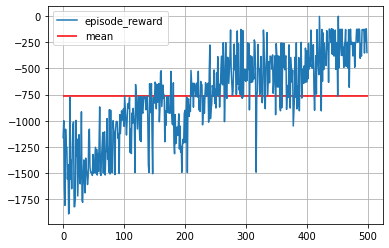

In [ ]:
plt.plot(ddpg_hist_fit.history['episode_reward'])
plt.hlines(np.mean(ddpg_hist_fit.history['episode_reward']),0,len(ddpg_hist_fit.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])

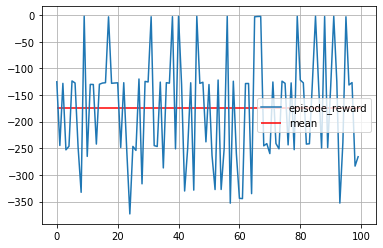

In [ ]:
plt.plot(ddpg_hist_test.history['episode_reward'])
plt.hlines(np.mean(ddpg_hist_test.history['episode_reward']),0,len(ddpg_hist_test.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])

## NAF

https://keras-rl.readthedocs.io/en/latest/agents/naf/

In [ ]:
# NAF

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

tf.compat.v1.experimental.output_all_intermediates(
    state=True
)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from rl.agents import NAFAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.core import Processor

class PendulumProcessor(Processor):
    def process_reward(self, reward):
        # The magnitude of the reward can be important. Since each step yields a relatively
        # high reward, we reduce the magnitude by two orders.
        return reward / 100.


ENV_NAME = 'Pendulum-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Build all necessary models: V, mu, and L networks.
V_model = Sequential()
V_model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
V_model.add(Dense(16))
V_model.add(Activation('relu'))
V_model.add(Dense(16))
V_model.add(Activation('relu'))
V_model.add(Dense(16))
V_model.add(Activation('relu'))
V_model.add(Dense(1))
V_model.add(Activation('linear'))
print(V_model.summary())

mu_model = Sequential()
mu_model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
mu_model.add(Dense(16))
mu_model.add(Activation('relu'))
mu_model.add(Dense(16))
mu_model.add(Activation('relu'))
mu_model.add(Dense(16))
mu_model.add(Activation('relu'))
mu_model.add(Dense(nb_actions))
mu_model.add(Activation('linear'))
print(mu_model.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
x = Concatenate()([action_input, Flatten()(observation_input)])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(((nb_actions * nb_actions + nb_actions) // 2))(x)
x = Activation('linear')(x)
L_model = Model(inputs=[action_input, observation_input], outputs=x)
print(L_model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
processor = PendulumProcessor()
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(theta=.15, mu=0., sigma=.3, size=nb_actions)
agent = NAFAgent(nb_actions=nb_actions, V_model=V_model, L_model=L_model, mu_model=mu_model,
                 memory=memory, nb_steps_warmup=100, random_process=random_process,
                 gamma=.99, target_model_update=1e-3, processor=processor)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3)                 0         
                                                                 
 dense_8 (Dense)             (None, 16)                64        
                                                                 
 activation_8 (Activation)   (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 activation_9 (Activation)   (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 activation_10 (Activation)  (None, 16)               

In [ ]:
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Entrenamiento
naf_hist_fit = agent.fit(env, nb_steps=100000, visualize=False, verbose=1, nb_max_episode_steps=200)
agent.save_weights('cdqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

Training for 100000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 140s 14ms/step - reward: -0.0726
50 episodes - episode_reward: -14.530 [-16.805, -9.688] - loss: 0.002 - mae: 0.021 - mean_q: 0.445

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 133s 13ms/step - reward: -0.0746
50 episodes - episode_reward: -14.926 [-16.564, -11.080] - loss: 0.001 - mae: 0.015 - mean_q: -0.225

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -0.0762
50 episodes - episode_reward: -15.234 [-16.575, -9.338] - loss: 0.002 - mae: 0.020 - mean_q: -0.777

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -0.0758
50 episodes - episode_reward: -15.153 [-16.583, -9.378] - loss: 0.004 - mae: 0.027 - mean_q: -1.290

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 140s 14ms/step - reward: -0.0766
50 episodes - episode_reward: -15.324 [-16.586, -10.290]

In [ ]:
# Evaluación
naf_hist_test = agent.test(env, nb_episodes=100, visualize=False, nb_max_episode_steps=200)

Testing for 100 episodes ...
Episode 1: reward: -9.700, steps: 200
Episode 2: reward: -9.936, steps: 200
Episode 3: reward: -16.560, steps: 200
Episode 4: reward: -10.712, steps: 200
Episode 5: reward: -9.880, steps: 200
Episode 6: reward: -9.795, steps: 200
Episode 7: reward: -9.515, steps: 200
Episode 8: reward: -10.047, steps: 200
Episode 9: reward: -10.837, steps: 200
Episode 10: reward: -15.832, steps: 200
Episode 11: reward: -10.759, steps: 200
Episode 12: reward: -16.545, steps: 200
Episode 13: reward: -16.519, steps: 200
Episode 14: reward: -10.007, steps: 200
Episode 15: reward: -16.537, steps: 200
Episode 16: reward: -9.407, steps: 200
Episode 17: reward: -9.652, steps: 200
Episode 18: reward: -16.311, steps: 200
Episode 19: reward: -16.548, steps: 200
Episode 20: reward: -16.389, steps: 200
Episode 21: reward: -9.692, steps: 200
Episode 22: reward: -9.862, steps: 200
Episode 23: reward: -16.570, steps: 200
Episode 24: reward: -10.067, steps: 200
Episode 25: reward: -10.663, 

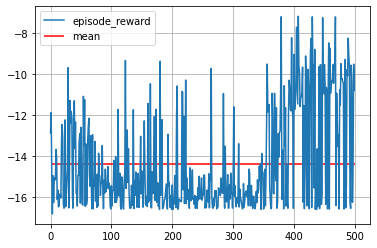

In [ ]:
plt.plot(naf_hist_fit.history['episode_reward'])
plt.hlines(np.mean(naf_hist_fit.history['episode_reward']),0,len(naf_hist_fit.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])

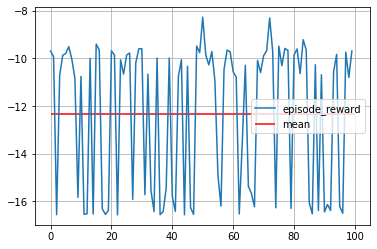

In [ ]:
plt.plot(naf_hist_test.history['episode_reward'])
plt.hlines(np.mean(naf_hist_test.history['episode_reward']),0,len(naf_hist_test.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])

Text(0.5, 1.0, 'DDPG vs NAF - Training')

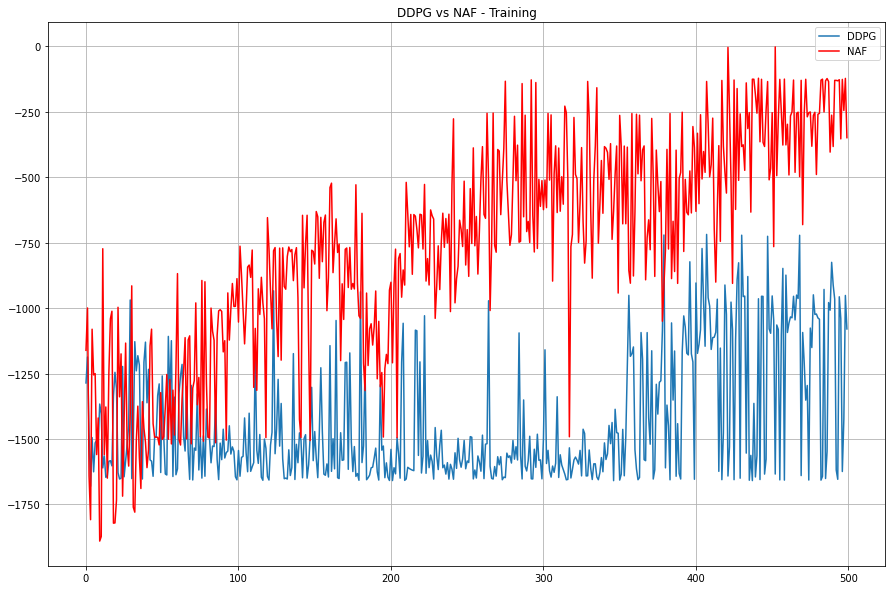

In [ ]:
# Visualizo la comparativa de ambos algoritmos
# NAF utiliza un procesador de reward que divide el rewar entre 100.
#  Para compararlo con DDPG es necesario volver a multiplicarlo por 100 para ajustarlo
plt.figure(figsize=(15,10))
plt.plot(np.array(naf_hist_fit.history['episode_reward'])*100)
plt.plot(ddpg_hist_fit.history['episode_reward'], c='r')
plt.grid()
plt.legend(["DDPG", 'NAF'])
plt.title('DDPG vs NAF - Training')

Text(0.5, 1.0, 'DDPG vs NAF - Training')

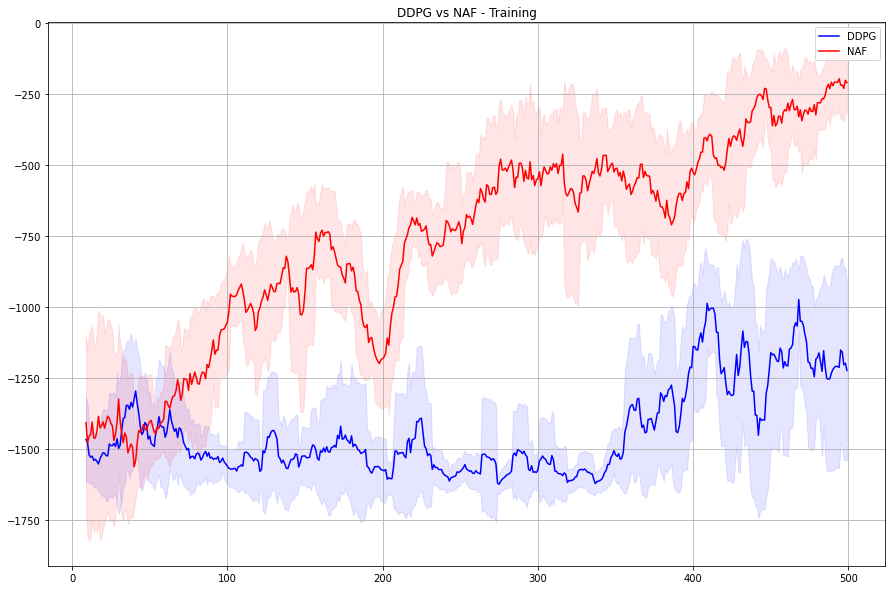

In [ ]:
# En lugar de plotear la gráfica en bruto, saco una media móvil y su desviación estandard
window = 10
plt.figure(figsize=(15,10))
naf_serie = pd.Series(np.array(naf_hist_fit.history['episode_reward'])*100)
ddpg_serie = pd.Series(ddpg_hist_fit.history['episode_reward'])
plt.plot(naf_serie.rolling(window).mean(), c='b')
plt.fill_between(naf_serie.index,
                     naf_serie.rolling(window).mean() - naf_serie.rolling(window).std(),
                     naf_serie.rolling(window).mean() + naf_serie.rolling(window).std(),
                     color='b',
                     alpha=0.1)
plt.plot(ddpg_serie.rolling(window).mean(), c='r')
plt.fill_between(ddpg_serie.index,
                     ddpg_serie.rolling(window).mean() - ddpg_serie.rolling(window).std(),
                     ddpg_serie.rolling(window).mean() + ddpg_serie.rolling(window).std(),
                     color='r',
                     alpha=0.1)
plt.grid()
plt.legend(["DDPG", 'NAF'])
plt.title('DDPG vs NAF - Training')